## Visualize Diagnostics

Plots diagnostic files produced by the function `save diagnostics` in the accuracy evaluation file `src/mmaction2/mmaction/core/evaluation/accuracy.py`

Dropdown(description='Diagnostics File:', index=31, layout=Layout(width='max-content'), options=('c:\\Users\\a…

IntSlider(value=5, continuous_update=False, description='SMA Window Size:', layout=Layout(width='max-content')…

Button(description='Save Plot', icon='save', style=ButtonStyle(), tooltip='Click to save the current plot')

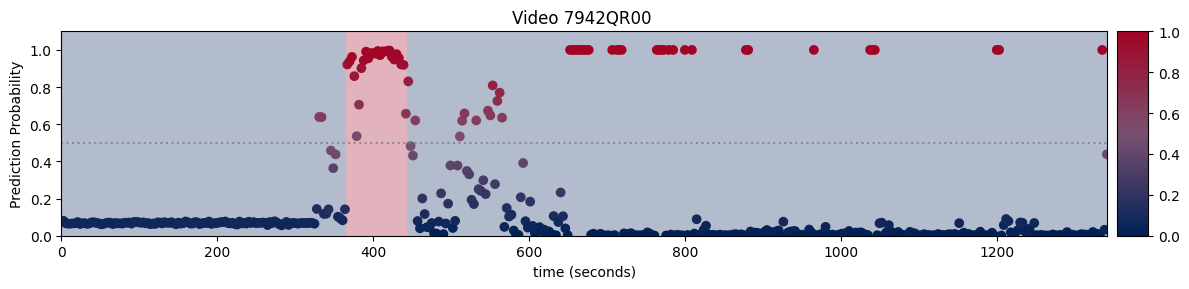

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import ast
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable


def parse_predictions(preds_str):
    preds = []
    preds_str = preds_str.strip()[1:-1]  # Remove the outer brackets
    preds_list = preds_str.split('array(')
    for pred in preds_list[1:]:
        pred_values = re.findall(r"[-+]?\d*\.\d+|\d+", pred.split(']')[0])
        preds.append(min(float(pred_values[1]), 1.0))  # Take the second value for the positive class probability
    return preds

def simple_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Flips the false positive and false negative entries, these are calculated correctly for 
# the metrics but the display CM function is opossite.
def flip_matrix_entries(matrix):
    if len(matrix) != 2 or len(matrix[0]) != 2 or len(matrix[1]) != 2:
        raise ValueError("Input must be a 2x2 matrix")
    
    matrix[0][1], matrix[1][0] = matrix[1][0], matrix[0][1]
    
    return matrix

def plot_predictions_and_labels(diagnostics_path, non_seizure_color:str="#bacfec", seizure_color:str="#ce8080", title="", ax=None):

    # Read and parse the diagnostics text file
    with open(diagnostics_path, 'r') as file:
        content = file.read()
    
    # Extract labels and preds
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))

    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))

    time_intervals = np.linspace(0, len(labels), len(labels))

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    else:
        fig = ax.figure
    
    # Create color map for labels and plot
    pred_cmap = LinearSegmentedColormap.from_list("pred_colormap", [non_seizure_color, "#7a5071", seizure_color])
    colors = [non_seizure_color, seizure_color]
    cmap = ListedColormap(colors)
    ax.hlines(y=[0.5], xmin=time_intervals[0], xmax=3*time_intervals[-1], linestyles='dotted', colors='grey', alpha=0.8)
    ax.imshow([labels], cmap=cmap, aspect='auto', extent=[time_intervals[0], 3*np.array(time_intervals[-1]), 0, 1.1], alpha=0.3)

    # Plot predictions as scatter plot
    scatter = ax.scatter(3*np.array(time_intervals[1:]), preds, label='Predictions', c=preds, cmap=pred_cmap, vmin=0, vmax=1, alpha=1)
    ax.set_ylabel('Prediction Probability')
    ax.set_xlabel('time (seconds)')
    ax.set_ylim(0, 1.1)
    ax.set_title(title)

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(scatter, cax=cax)

    plt.tight_layout()
    plt.show()
    return fig

def plot_diagnostics(diagnostics_path, sma_window_size=5, title=""):
    # Read and parse the diagnostics text file
    with open(diagnostics_path, 'r') as file:
        content = file.read()
    
    # Extract confusion matrix
    confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
    confusion_matrix_match = confusion_matrix_pattern.search(content)
    if confusion_matrix_match:
        cm = np.array([
            list(map(int, confusion_matrix_match.group(1).split())),
            list(map(int, confusion_matrix_match.group(2).split()))
        ])
        cm = flip_matrix_entries(cm)
    
    # Extract labels
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))
        labels2 = np.array(labels) + 1.1

    print(labels)
    print(f"Number Labels: {len(labels)}")

    # Extract predictions
    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))
        preds2 = np.array(preds) + 1.1

    print(preds)
    print(f"Number Preds: {len(preds)}")

    # Extract images saved for ROC and PC curves
    roc_pr_pattern = re.compile(r'Combined ROC and Precision-Recall Curves saved at: (.*)')
    roc_pr_match = roc_pr_pattern.search(content)
    roc_pr_image_path = None
    if roc_pr_match:
        roc_pr_image_path = roc_pr_match.group(1).strip()
    
    # Calculate the time intervals based on the length of the video
    time_intervals = np.linspace(0, len(labels), len(labels))

    # Calculate the simple moving average of the predictions
    sma_preds = simple_moving_average(preds, sma_window_size)
    sma_preds2 = np.array(sma_preds) + 1.1

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    gs = axs[0, 0].get_gridspec()
    # Remove the underlying axes
    for ax in axs[0, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[0, :])

    # Plot labels and predictions over time
    axbig.plot(time_intervals, labels, label='Labels', color='blue')
    axbig.scatter(time_intervals[1:], preds, label='Predictions', color='red', alpha=0.3)
    axbig.plot(time_intervals, labels2, color='blue')
    axbig.plot(time_intervals[sma_window_size:], sma_preds2, label=f'SMA Predictions (window={sma_window_size})', color='green', alpha=0.5)
    axbig.set_xlabel('Clip')
    axbig.set_ylabel('Class')
    axbig.set_ylim(0,2.2)
    axbig.set_title(title + 'Labels and Predictions over Time')
    axbig.hlines([0.5,1.6],[0,0],[max(time_intervals),max(time_intervals)], colors=['grey','grey'],linestyles=['dashed','dashed'] )
    axbig.legend()

    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues', values_format='d', ax=axs[1, 0])
    axs[1, 0].set_title('Confusion Matrix')

    # Plot ROC and Precision-Recall Curves image
    if roc_pr_image_path and os.path.exists(roc_pr_image_path):
        roc_pr_image = plt.imread(roc_pr_image_path)
        axs[1, 1].imshow(roc_pr_image)
        axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

Videos_key = ['00105B00', '00105C00', '00108500', '00108700', '00200100', '00200200', '22200Q01', '22200S00', '22200T00', '77952GP00', '7913ZY00', '7940HO00', '7940HU00', '7940K700', '79410R00', '7941CO00', '7941D100', '7941D200', '7941D300', '7941D400', '7941D500', '7941D600', '7941E901', '7941EA00', '7941EC00', '7941LY00', '7941M700', '7942GT00', '7942GU00', '7942GZ00', '7942QQ00', '7942QR00', '79519000', '7951EX00', '7952DG00', '7952DP00', '7953A100', '7953A400', '7962TA00', '7964JU00', '7970IA00', '79719R00', '7971C500', '7971C700', '7971H000', '7971Q500', '7971UI00', '7972M300', '7972OT00']

def get_files(dir):
    files = []
    for d,r,f in os.walk(dir):
        for file in f:
            files.append(os.path.join(d,file))
    return files

current_dir = os.path.join(os.getcwd(), 'Test_results_cropped')
current_options = get_files(current_dir)
# Create widgets for diagnostics file selection and SMA window size
# Create widgets for diagnostics file selection and SMA window size
diagnostics_file_widget = widgets.Dropdown(
    options=current_options,
    description='Diagnostics File:',
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

sma_window_size_widget = widgets.IntSlider(
    value=5, min=1, max=20, step=1,
    description='SMA Window Size:',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

s_color = "#a30324"
ns_color = "#002157"

# Create a save button
save_button = widgets.Button(
    description='Save Plot',
    disabled=False,
    button_style='',
    tooltip='Click to save the current plot',
    icon='save'
)

current_figure = None

def update_plot(change=None):
    global current_figure
    clear_output(wait=True)
    display(diagnostics_file_widget, sma_window_size_widget, save_button)
    title = f"Video {Videos_key[diagnostics_file_widget.index]} "
    current_figure = plot_predictions_and_labels(diagnostics_file_widget.value, title=title, non_seizure_color=ns_color, seizure_color=s_color)

def save_plot(b):
    global current_figure
    if current_figure is not None:
        # Create 'good_images' directory if it doesn't exist
        os.makedirs('good_images', exist_ok=True)
        
        # Generate filename based on the current video key
        filename = f"good_images/plot_{Videos_key[diagnostics_file_widget.index]}.png"
        
        # Save the figure
        current_figure.savefig(filename, dpi=800, bbox_inches='tight')
        print(f"Plot saved as {filename}")
    else:
        print("No plot to save. Please generate a plot first.")

# Observe changes in the widgets
diagnostics_file_widget.observe(update_plot, names='value')
sma_window_size_widget.observe(update_plot, names='value')
save_button.on_click(save_plot)

# Initial display of widgets
display(diagnostics_file_widget, sma_window_size_widget, save_button)
update_plot()

### Combined ROC plots

In [14]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import ast

def extract_data_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        
        labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
        labels_match = labels_pattern.search(content)
        if labels_match:
            labels = ast.literal_eval(labels_match.group(1))

        preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
        preds_match = preds_pattern.search(content)
        if preds_match:
            preds = parse_predictions(preds_match.group(1))
    
    return labels[1:], preds

def plot_auc_roc_curve(directory):
    plt.figure()
    
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if file_path.endswith("txt"):
            labels, preds = extract_data_from_file(file_path)
        
        if labels is None or preds is None:
            continue
        
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC by video (uncropped)')
    plt.show()


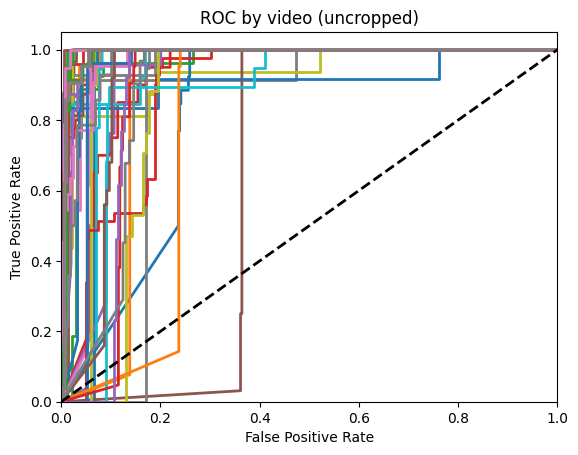

In [15]:
# Example usage
directory = os.path.join(os.getcwd(), "Test_results_uncropped")
plot_auc_roc_curve(directory)

### Plot all time series

In [162]:
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr

s_color = "#a30324"
ns_color = "#002157"
m_color = "#7a5071"

def plot_predictions_and_labels_ax(diagnostics_path, non_seizure_color:str=ns_color, seizure_color:str=s_color, middle_color:str=m_color, title="", ax=None, cm_only:bool=False):
    # Read and parse the diagnostics text file
    with open(diagnostics_path, 'r') as file:
        content = file.read()

    # Extract confusion matrix
    confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
    confusion_matrix_match = confusion_matrix_pattern.search(content)
    if confusion_matrix_match:
        cm = np.array([
            list(map(int, confusion_matrix_match.group(1).split())),
            list(map(int, confusion_matrix_match.group(2).split()))
        ])
        cm = flip_matrix_entries(cm)
        acc = (100*(cm[0,0]+cm[1,1])/(sum(sum(cm))))

    if cm_only: return cm, _

    sma_window_size = 5
    # Extract labels and preds
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))

    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))
        sma_preds = simple_moving_average(preds, sma_window_size)


    time_intervals = np.linspace(0, len(labels), len(labels))
    video_length = 3*(len(labels))

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))  # Changed height to 4 to maintain 3:1 ratio
    
    # Create color map for labels and plot
    pred_cmap = LinearSegmentedColormap.from_list("pred_colormap", [non_seizure_color, middle_color, seizure_color])
    colors = [non_seizure_color, seizure_color]
    cmap = ListedColormap(colors)
    ax.imshow([labels], cmap=cmap, aspect='auto', extent=[time_intervals[0], 3*np.array(time_intervals[-1]), 0, 1.1], alpha=0.3)

    # Plot predictions as scatter plot
    ax.hlines(y=0.5, xmin=time_intervals[0], xmax=3*np.array(time_intervals[-1]), linestyles='dashed',colors='grey')
    ax.plot(3*np.array(time_intervals[sma_window_size:]), sma_preds, alpha=0.5)
    ax.scatter(3*np.array(time_intervals[1:]), preds, label='Predictions', c=preds, cmap=pred_cmap, vmin=0, vmax=1, alpha=1)
    ax.set_ylabel('Prediction Probability')
    ax.set_xlabel('time (seconds)')
    ax.set_ylim(0, 1.1)
    ax.set_title(title)
    #ax.legend()
    return(cm, video_length)

def plot_all_txt_files(directory_path):
    # Get all .txt files in the directory
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    if not txt_files:
        print("No .txt files found in the directory.")
        return

    # Calculate the grid dimensions
    n_files = len(txt_files)
    n_cols = min(8, n_files * 2)  # Max 6 columns (doubled from 3)
    n_rows = (n_files - 1) // (n_cols // 2) + 1

    # Create a figure with subplots
    fig = plt.figure(figsize=(25, 2 * n_rows))  # Doubled width from 15 to 30
    gs = GridSpec(n_rows, n_cols, figure=fig, height_ratios=[1]*n_rows, width_ratios=[1]*n_cols)
    accs = []
    video_lengths = []
    
    for i, txt_file in enumerate(txt_files):
        row = i // (n_cols // 2)
        col = (i % (n_cols // 2)) * 2
        
        # Create a subplot spanning two columns
        ax = fig.add_subplot(gs[row, col:col+2])
        title = f"Video {Videos_key[i]} "
        
        # Plot the predictions and labels
        file_path = os.path.join(directory_path, txt_file)
        cm, video_length = plot_predictions_and_labels_ax(file_path, title=title, ax=ax)
        acc = (100*(cm[0,0]+cm[1,1])/(sum(sum(cm))))
        accs.append(acc)
        video_lengths.append(video_length)

    print(f"Mean Accuracy: {(np.mean(accs)):.2f}%")
    print(f"Median Accuracy: {(np.median(accs)):.2f}%")

    correlation_coefficient, p_value = pearsonr(accs, video_lengths)
    print(f"Correlation coefficient between accuracy and video length: {correlation_coefficient:.4f}")
    print(f"P-value: {p_value:.4f}")

    plt.tight_layout()
    plt.show()

    return(accs, video_lengths)

Mean Accuracy: 91.37%
Median Accuracy: 94.97%
Correlation coefficient between accuracy and video length: 0.4199
P-value: 0.0027


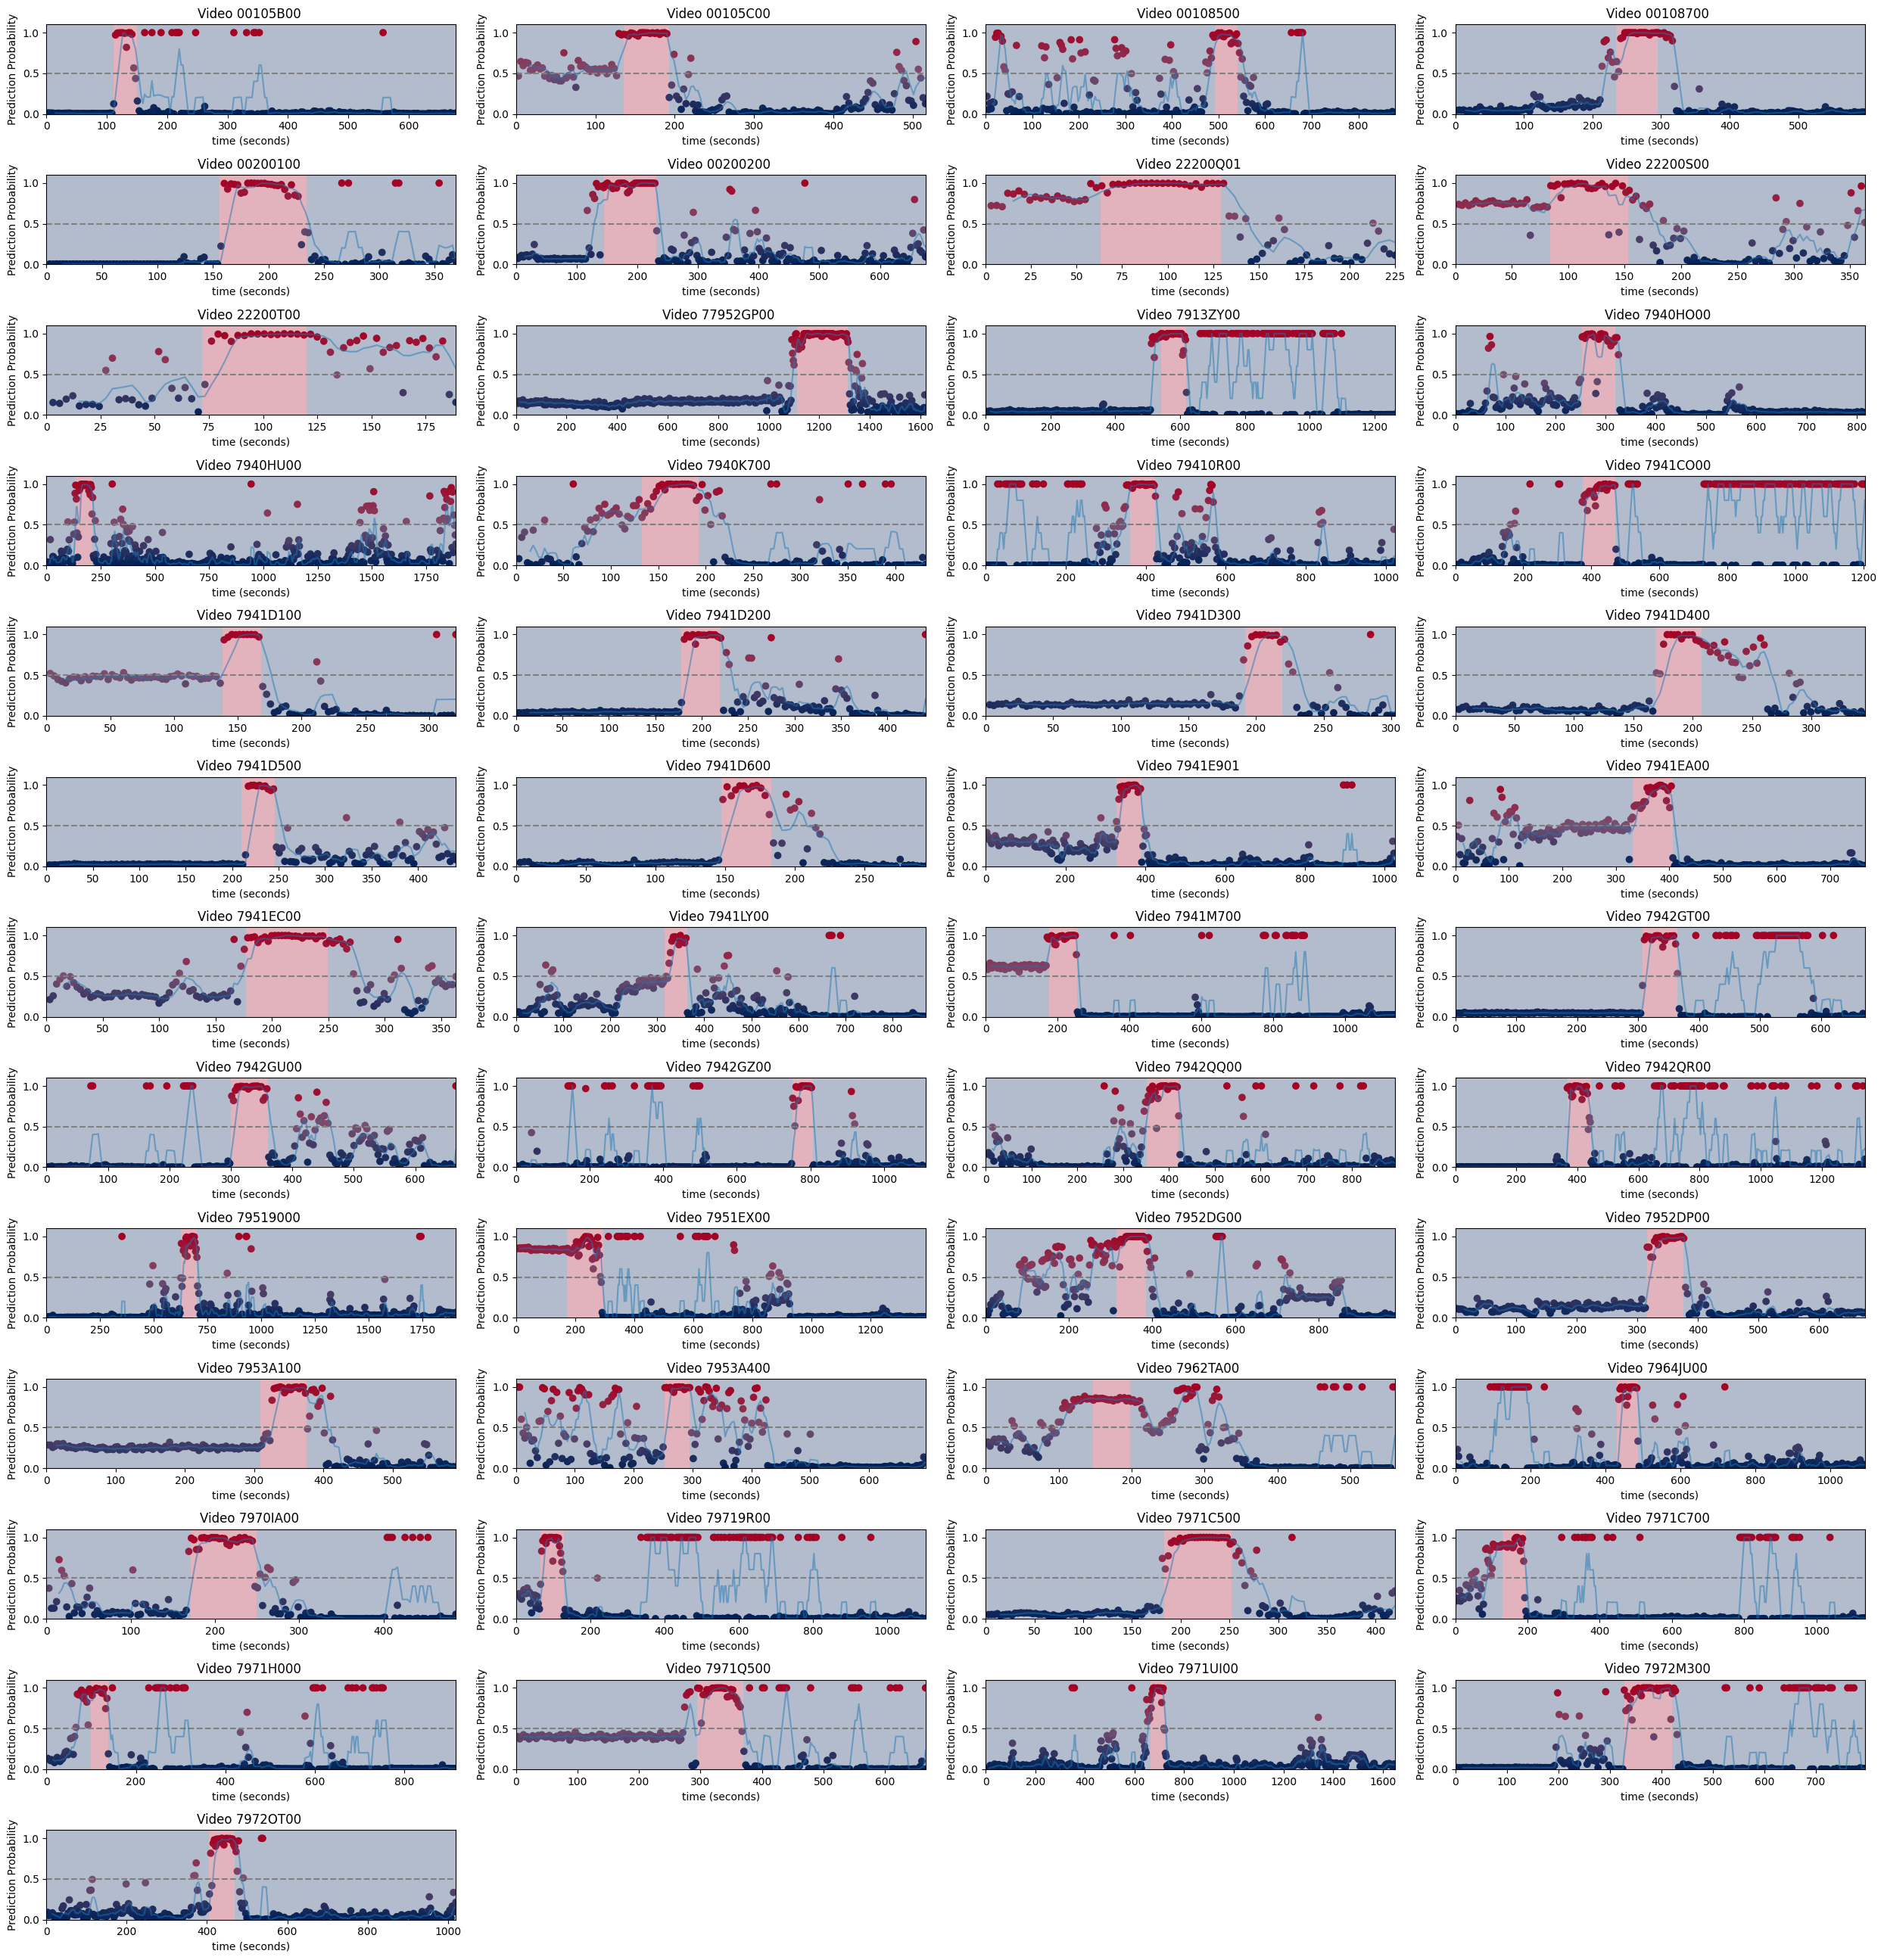

In [163]:
ac,vl = plot_all_txt_files(os.path.join(os.getcwd(),"Test_results_uncropped"))

Mean Accuracy: 93.32%
Median Accuracy: 96.20%
Correlation coefficient between accuracy and video length: 0.2373
P-value: 0.1006


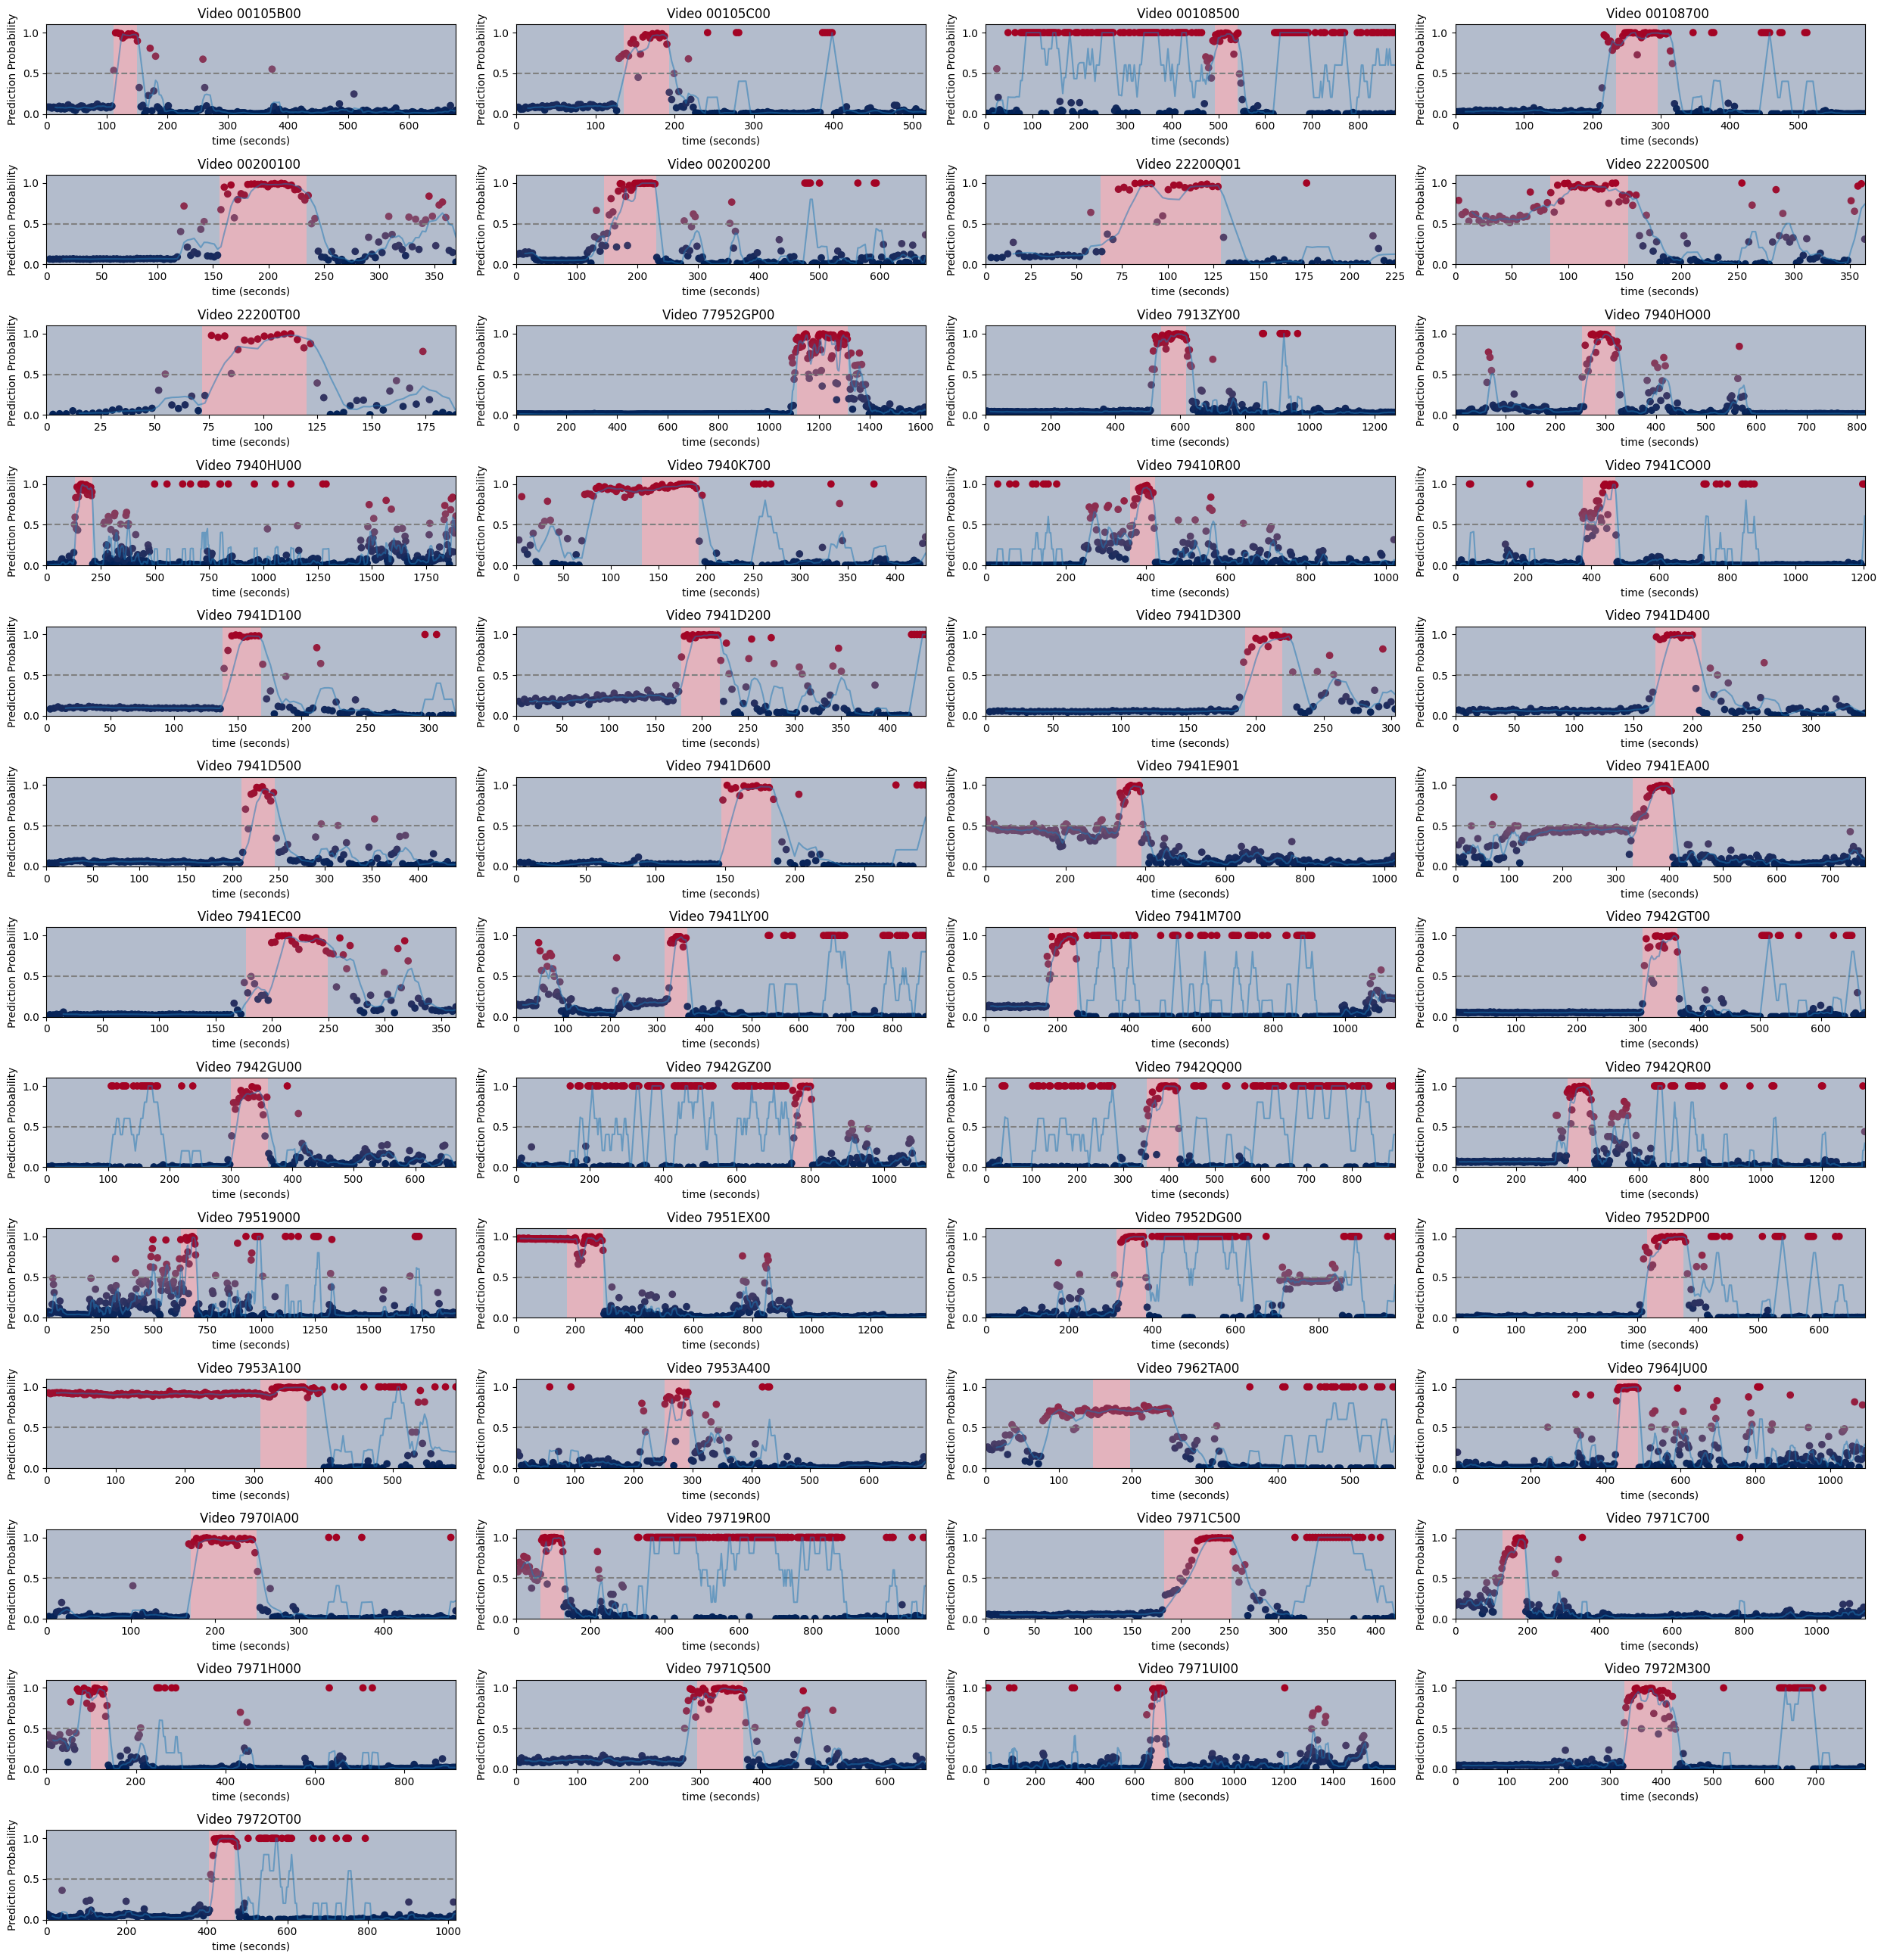

In [164]:
ac_c, vl_c = plot_all_txt_files(os.path.join(os.getcwd(),"Test_results_cropped"))

### Final bigboy stats

In [157]:
def process_diagnostics_files(directory_path):
    total_confusion_matrix = None
    metrics = {
        'Cross-entropy loss': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': [],
        'AUC': []
    }
    weights = []
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            with open(os.path.join(directory_path, filename), 'r') as file:
                content = file.read()
                
                # Extract confusion matrix
                confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
                confusion_matrix = confusion_matrix_pattern.search(content)
                if confusion_matrix:
                    cm = np.array([
                        list(map(int, confusion_matrix.group(1).split())),
                        list(map(int, confusion_matrix.group(2).split()))
                    ])
                    if total_confusion_matrix is None:
                        total_confusion_matrix = np.array(cm)
                    else:
                        total_confusion_matrix += np.array(cm)
                    
                    # Calculate weight (total number of predictions)
                    weight = np.sum(cm)
                    weights.append(weight)
                
                # Extract metrics
                for metric in metrics.keys():
                    match = re.search(f'{metric}: ([\d.]+)', content)
                    if match:
                        metrics[metric].append(float(match.group(1)))
    
    # Calculate weighted average metrics
    avg_metrics = {}
    for metric, values in metrics.items():
        if values and len(values) == len(weights):
            avg_metrics[metric] = np.average(values, weights=weights)
        else:
            avg_metrics[metric] = np.nan  # or some other appropriate value
    
    return total_confusion_matrix, avg_metrics

def print_results(confusion_matrix, metrics):
    print("Sum of Confusion Matrices:")
    print(np.array2string(confusion_matrix, separator=', '))
    print("\nAverage Metrics:")
    for metric, value in metrics.items():
        print(f"{metric:<20} {value:.4f}")

In [158]:
cm, metrics = process_diagnostics_files(os.path.join(os.getcwd(),"Test_results_cropped"))
cm_uc, metrics_uc = process_diagnostics_files(os.path.join(os.getcwd(),"Test_results_uncropped"))
print("---Cropped Results---")
print_results(cm, metrics)
print("\n---Uncropped Results---")
print_results(flip_matrix_entries(cm_uc), metrics_uc)

---Cropped Results---
Sum of Confusion Matrices:
[[11555,    83],
 [  649,   983]]

Average Metrics:
Cross-entropy loss   nan
Precision            0.6748
Recall               0.9194
F1 Score             0.7596
Accuracy             0.9448
AUC                  0.9835

---Uncropped Results---
Sum of Confusion Matrices:
[[11380,    40],
 [  824,  1026]]

Average Metrics:
Cross-entropy loss   nan
Precision            0.6592
Recall               0.9595
F1 Score             0.7553
Accuracy             0.9349
AUC                  0.9877
